In [1]:
import sys
from __future__ import division

In [19]:
import numpy as np
from phasor.utilities.ipynb.displays import *
from phasor.utilities.ipynb.sympy import *

import declarative

from declarative.bunch import (
    DeepBunch
)

import phasor.math.dispatched as dmath 
#import phasor.math.dispatch_sympy

Sympy version:  1.0


In [3]:
import phasor.utilities.version as version
print(version.foundations_version())

from phasor.utilities.np import logspaced

from phasor import optics
from phasor import base 
from phasor import signals 
from phasor import system
from phasor import readouts 

import scipy.signal

b'2017-09-29 14:18:38 -0400 (bbb2b427cdfd3d3fc1a626fa4fa5404882cc9820)'


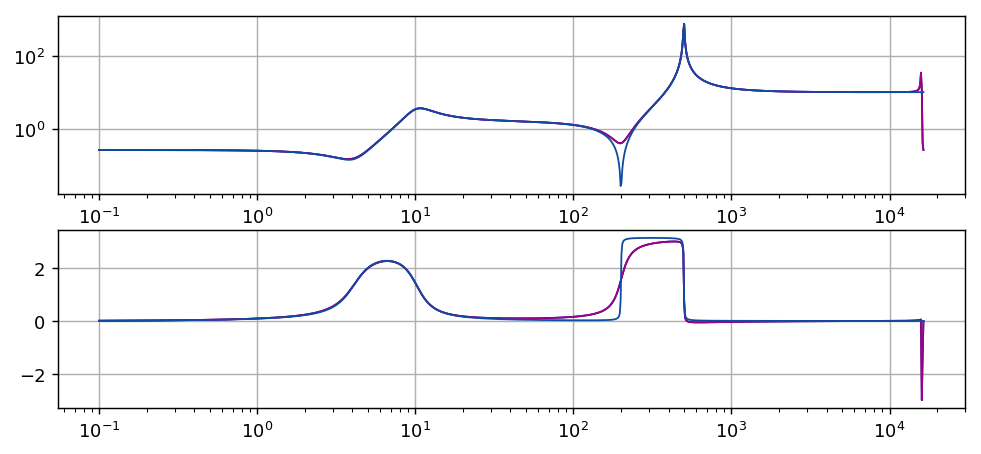

In [4]:
F_AC = np.linspace(0, 16384, 1000)
F_AC = logspaced(.1, 16384, 1000)
    
ZPKs = (
    [
        2 * np.pi * (-1 + 4j), 
        2 * np.pi * (-1 - 4j),
        2 * np.pi * (-1 + 200j), 
        2 * np.pi * (-1 - 200j)
    ], 
    [
        2 * np.pi * (-2 + 10j), 
        2 * np.pi * (-2 - 10j),
        2 * np.pi * (-2 + 500j), 
        2 * np.pi * (-2 - 500j),
    ], 
    10
)

F_nyquist = 16384 / 2
z,p,k, dt = scipy.signal.cont2discrete(ZPKs, dt = 1 / (2 * F_nyquist))
ZPKz = z,p,k

b,a = scipy.signal.zpk2tf(*ZPKz)


Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz_zpk(*ZPKz , worN = F_AC / F_nyquist * np.pi)
F_exact = h
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

w, h = scipy.signal.freqz(b, a , worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

w, h = scipy.signal.freqs_zpk(*ZPKs , worN = F_AC  * np.pi * 2)
#F_exact = h
Fb.ax0.loglog(F_AC, abs(h), label = 'cont')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'cont')

In [62]:
Z = np.exp(-1j * np.pi * F_AC / F_nyquist)
Z_a = np.vstack([Z**j for j in range(5)]).T
Z_b = np.vstack([Z**j for j in range(5)]).T

In [63]:
Z_a.shape

In [64]:
M_b = np.einsum('ij,i->ij', Z_b, 1/F_exact)
M_a = Z_a
M_b2 = Z_b
M_a2 = np.einsum('ij,i->ij', Z_a, F_exact)

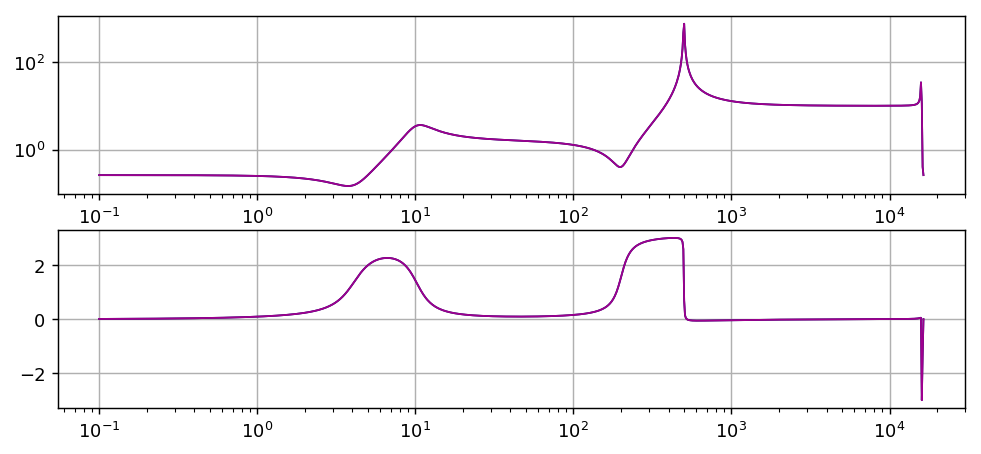

In [65]:
den = np.einsum('ij,j->i', Z_a, a)
num = np.einsum('ij,j->i', Z_b, b)

Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz_zpk(*ZPKz , worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

h = num/den
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

In [77]:
X = np.block([[M_b, -M_a]])
red = np.einsum('ji,jk->ik', X, X.conjugate())
red.shape
X.shape
ZZ = np.einsum('ij,jk->ik', np.linalg.pinv(M_a), M_b)
ZZ.shape

In [67]:
@np.vectorize
def pimg(v):
    return "{0:.2f}".format(v)
print(tabulate.tabulate(pimg(ZZ)))

----------  ----------  ----------  ----------  ----------
0.47+0.42j  0.37+0.42j  0.37+0.43j  0.37+0.43j  0.37+0.43j
0.49+0.09j  0.59+0.09j  0.49+0.09j  0.49+0.09j  0.49+0.09j
0.47-0.16j  0.47-0.16j  0.56-0.16j  0.46-0.16j  0.46-0.16j
0.35-0.38j  0.35-0.39j  0.35-0.39j  0.44-0.39j  0.34-0.39j
0.06-0.61j  0.05-0.61j  0.05-0.61j  0.04-0.61j  0.14-0.61j
----------  ----------  ----------  ----------  ----------


In [68]:
(a - np.einsum('jk,k->j', ZZ, b))/a

array([  1.06581410e-14 +6.30606678e-14j,
         1.12135471e-15 -3.13979320e-15j,
         4.65283830e-15 +3.97742629e-15j,
        -1.67338349e-14 -6.17691894e-15j,   3.22953969e-15 +1.15817975e-14j])

In [70]:
np.linalg.eig(ZZ)

(array([ 1.81578030 -6.37359419e-01j,  0.08500331 -9.58689350e-03j,
         0.09822783 +1.03703591e-04j,  0.09939930 -5.61647389e-05j,
         0.09971369 +2.44536300e-05j]),
 array([[-0.32668603+0.33759616j, -0.40035165-0.35868899j,
          0.31733611-0.03154668j,  0.08307365-0.04134708j,
         -0.05726187-0.02157252j],
        [-0.03958952+0.41131776j, -0.36316930-0.01276614j,
         -0.03342173-0.09361889j, -0.25625147-0.04102785j,
          0.17830129+0.0151044j ],
        [ 0.16429153+0.37455906j, -0.12161271+0.17140804j,
         -0.52658223-0.01363293j, -0.12972808+0.19729284j,
         -0.49358866+0.05555426j],
        [ 0.34111638+0.26146005j,  0.22928649+0.20884661j,
         -0.40868184+0.13987263j,  0.78747128+0.j        ,  0.75444590+0.j        ],
        [ 0.50650519+0.j        ,  0.66230376+0.j        ,
          0.65143011+0.j        , -0.48465791-0.11525164j,
         -0.38196632-0.0493284j ]]))

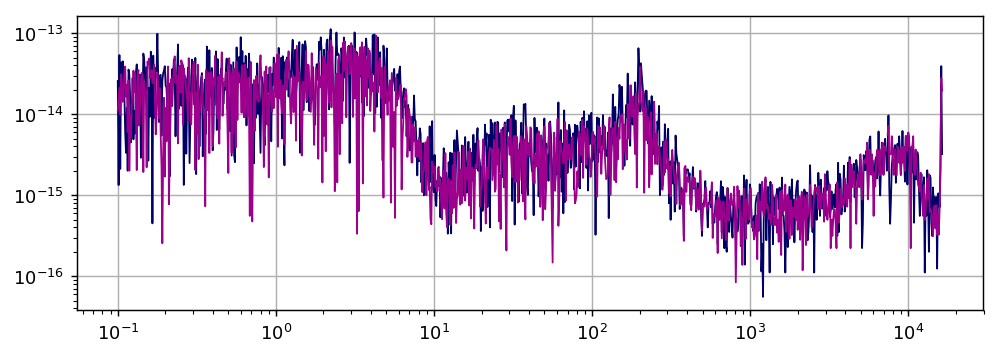

In [71]:
res_block = np.einsum('ij,j->i', X, np.block([[b, a]]).reshape(-1))
res_test = F_exact - num / den
res_test = den - num / F_exact
Fb = mplfigB(Nrows=1)
Fb.ax0.loglog(F_AC, abs(res_block), label = 'discrete')
Fb.ax0.loglog(F_AC, abs(res_test), label = 'discrete')
#Fb.ax0.loglog(F_AC, abs(F_exact), label = 'discrete')
#Fb.ax0.loglog(F_AC, abs(num / den), label = 'discrete')

In [91]:
U,S,V = np.linalg.svd(X)
print(V[-1, 0:5] / b)
V[-1, 5:10] / a

[ 0.01201487 +0.00000000e+00j  0.01201487 +7.74030551e-13j
  0.01201487 +1.54418974e-12j  0.01201487 +2.31260488e-12j
  0.01201487 +3.08145177e-12j]


array([ 0.01201487 +1.63064007e-16j,  0.01201487 +7.77364701e-13j,
        0.01201487 +1.54059105e-12j,  0.01201487 +2.30390522e-12j,
        0.01201487 +3.08150462e-12j])

In [96]:
b_fit = V[-1, 0:5]
a_fit = V[-1, 5:10]
b_fit / b_fit[0] / (b / b[0])

array([ 1. +0.00000000e+00j,  1. +6.44226901e-11j,  1. +1.28523166e-10j,
        1. +1.92478484e-10j,  1. +2.56469737e-10j])

In [97]:
a_fit / a_fit[0] / (a / a[0])

array([ 1. +0.00000000e+00j,  1. +6.46866200e-11j,  1. +1.28210075e-10j,
        1. +1.91740838e-10j,  1. +2.56460565e-10j])

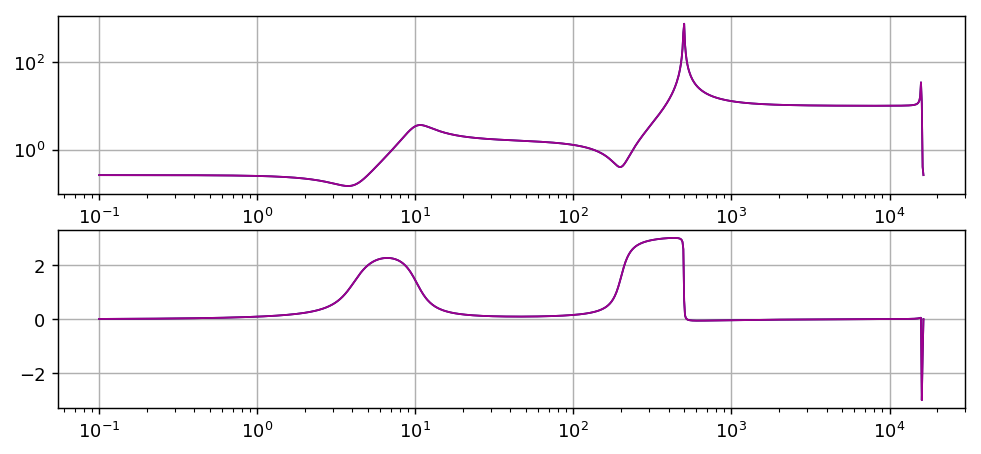

In [98]:
Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz(b, a, worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

w, h = scipy.signal.freqz(b_fit, a_fit, worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')